In [113]:
import torch
import numpy as np
import plyfile
import laspy
import os
import json
import glob

from PIL import Image
from os.path import join
from scipy.spatial.transform import Rotation
import struct

In [114]:
# x, y, z, intensity, ring_index
def bin_to_tensor(path):
    points = []
    with open(path, 'rb') as file:
        while True:
            data = file.read(4)
            if not data:
                break
            points.append(struct.unpack('f', data)[0])
    points = torch.tensor(points)
    
    return points.reshape(-1 ,5)

def image_to_tensor(path):
    image = Image.open(path)
    i_np = np.array(image)
    i_tensor = torch.from_numpy(i_np)
    
    return i_tensor.permute(2, 0, 1) 

def read_json(path:str):
    with open(path, 'r') as json_file:
        return json.load(json_file)

def get_rotation_matrix(w:float, x:float, y:float, z:float)->torch.Tensor:
    rotation = Rotation([x, y, z, w])
    return torch.from_numpy(rotation.as_matrix()).type(torch.float32)

# rgb (3, h, w), xy (n, 2)
def get_rgb_bilinear(img, xy):
    x = xy[:,0]
    y= xy[:, 1]
    
    x0 = torch.floor(x).int()
    y0 = torch.floor(y).int()
    x1 = torch.ceil(x).int()
    y1 = torch.ceil(y).int()

    lt = img[:, y0, x0]
    lb = img[:, y1, x0]
    rt = img[:, y0, x1]
    rb = img[:, y1, x1]
    
    wa = ((x1.float() - x) * (y1.float() - y)).unsqueeze(0)
    wb = ((x1.float() - x) * (y - y0.float())).unsqueeze(0)
    wc = ((x - x0.float()) * (y1.float() - y)).unsqueeze(0)
    wd = ((x - x0.float()) * (y - y0.float())).unsqueeze(0)
    
    return (lt * wa + lb * wb + rt * wc + rb * wd).type(torch.uint8).transpose(0, 1)

def color_points(image:torch.Tensor, points:torch.Tensor, pixels:torch.Tensor, depth:torch.Tensor):
    n_points = points.size(0)
    x = pixels[:, 0]
    y = pixels[:, 1]
    
    mask = torch.ones(n_points, dtype=bool)
    mask = torch.logical_and(mask, depth > 1.0)
    mask = torch.logical_and(mask, x > 1)
    mask = torch.logical_and(mask, x < 1600 - 1)
    mask = torch.logical_and(mask, y > 1)
    mask = torch.logical_and(mask, y < 900 - 1)
    
    rgb = get_rgb_bilinear(image, pixels[mask,:2])
    points[mask,5:8] = rgb.float()
    points[mask,8] = 1.0
    
    return points

In [115]:

MAX_DISTANCE = 20.0
MIN_DISTANCE = 2.0

class EgoPose():
    def __init__(self, json_data) -> None:
        rotation = json_data['rotation']
        self.rotation:torch.Tensor = get_rotation_matrix(rotation[0], rotation[1], rotation[2], rotation[3])
        self.timestamp:int = json_data['timestamp']
        self.tranlation:torch.Tensor = torch.tensor(json_data['translation'])
        self.token:str = json_data['token']

class CalibratedSensor():
    def __init__(self, json_data) -> None:
        rotation = json_data['rotation']
        self.rotation:torch.Tensor = get_rotation_matrix(rotation[0], rotation[1], rotation[2], rotation[3])
        self.tranlation:torch.Tensor = torch.tensor(json_data['translation'])
        self.token:str = json_data['token']
        self.sensor_token:str = json_data['sensor_token']
        
        camera_intrinsic = json_data['camera_intrinsic']
        self.is_camera:bool = len(camera_intrinsic) > 0
        if self.is_camera:
            self.camera_intrinsic:torch.Tensor = torch.tensor(camera_intrinsic)

# class Camera():
#     def __init__(self) -> None:
#         self.token:str

SAMPLE_DATA_TYPE = {
    'RADAR': 0,
    'LIDAR': 1,
    'CAM_FRONT_LEFT': 2,
    'CAM_FRONT_RIGHT': 3,
    'CAM_BACK_LEFT': 4,
    'CAM_BACK_RIGHT': 5,
    'CAM_FRONT': 6,
    'CAM_BACK': 7,
}

class SampleData():
    def __init__(self, root:str, json_data) -> None:
        self.timestamp:int = json_data['timestamp']
        self.token:str = json_data['token']
        self.sample_token:str = json_data['sample_token']
        self.ego_pose_token:str = json_data['ego_pose_token']
        self.calibrated_sensor_token:str = json_data['calibrated_sensor_token']
        self.filename:str = join(root, json_data['filename'])
        self.prev:str = json_data['prev']
        self.next:str = json_data['next']
        self.height:int = json_data['height']
        self.width:int = json_data['width']
        self.is_key_frame:bool = json_data['is_key_frame']
        
        for key, value in SAMPLE_DATA_TYPE.items():
            if self.filename.find(key) > -1:
                self.type = value
                break
        
        
    def set_calibrated_sensor(self, calibrated_sensor:CalibratedSensor):
        self.rotation:torch.Tensor = calibrated_sensor.rotation
        self.translation:torch.Tensor = calibrated_sensor.tranlation
        self.is_camera:bool = calibrated_sensor.is_camera
        if self.is_camera:
            self.camera_intrinsic:torch.Tensor = calibrated_sensor.camera_intrinsic
            
    def set_ego_pose(self, ego_pose:EgoPose):
        self.ego_rotation:torch.Tensor = ego_pose.rotation
        self.ego_translation:torch.Tensor = ego_pose.tranlation
        
    # return (n, 9) x, y, z, intensity, ring_index, red, green, blue, colored
    def get_points(self)->torch.Tensor:
        points = bin_to_tensor(self.filename)
        
        n_points = points.size(0)
        points = torch.concatenate([points, torch.zeros((n_points, 4))], dim=1)
        
        coords = points[:,:3]
        # distance filter
        distance = torch.sum(torch.pow(coords, 2), dim=1)
        mask = distance > (MIN_DISTANCE**2)
        mask = torch.logical_and(mask, distance < (MAX_DISTANCE**2))
        points = points[mask]
        
        coords = points[:,:3]
        # lidar to ego_vehicle
        coords = torch.matmul(coords, self.rotation.T) + self.translation
        # ego_vehicle to world
        coords = torch.matmul(coords, self.ego_rotation.T) + self.ego_translation
        points[:,:3] = coords
        
        return points
    
    # return (3, h, w)
    def get_image(self)->torch.Tensor:
        img = image_to_tensor(self.filename)
        return img
        
        
    # in : points (n, 3), out : world_pos (n, 3)
    def to_world(self, points:torch.Tensor):
        ego_pose = torch.matmul(points, self.rotation.T) + self.translation
        world_pos = torch.matmul(ego_pose, self.ego_rotation.T) + self.ego_translation
        
        return world_pos
    
    # in : points (n, dimension), out : pixels (n, 2)
    def points_to_pixel(self, points:torch.Tensor):
        points = points[:,:3]
        # world to ego_vehicle
        points = torch.matmul(points - self.ego_translation, self.ego_rotation)
        # ego_vehicle to camera
        points = torch.matmul(points - self.translation, self.rotation)
        
        depth = points[:,2]
        viewpad = torch.eye(4)
        viewpad[:self.camera_intrinsic.shape[0], :self.camera_intrinsic.shape[1]] = self.camera_intrinsic
        
        num_points = points.size(0)
        points = torch.concatenate((points.T, torch.ones(1, num_points)))
        points = torch.matmul(viewpad, points)
        points = points[:3, :]
        points = points / points[2:3, :].repeat(3, 1).reshape(3, num_points)
        
        return points.T, depth
    
    def points_to_pixel2(self, points:torch.Tensor):
        num_points = points.size(0)
        points = points.T
        points = points[:3,:]
        # world to ego_vehicle
        points -= self.ego_translation.unsqueeze(0).T
        points = torch.matmul(self.ego_rotation.T, points)
        # ego_vehicle to camera
        points -= self.translation.unsqueeze(0).T
        points = torch.matmul(self.rotation.T, points)
        
        depths = points[2, :]
        
        viewpad = torch.eye(4)
        viewpad[:self.camera_intrinsic.shape[0], :self.camera_intrinsic.shape[1]] = self.camera_intrinsic
        
        
        points = torch.concatenate((points, torch.ones(1, num_points)))
        points = torch.matmul(viewpad, points)
        points = points[:3, :]
        points = points / points[2:3, :].repeat(3, 1).reshape(3, num_points)
        
        return points.T, depths.T
        
class Sample():
    def __init__(self, json_data) -> None:
        self.timestamp:int = json_data['timestamp']
        self.token:str = json_data['token']
        self.scene_token:str = json_data['scene_token']
        self.prev = json_data['prev']
        self.next = json_data['next']
        # self.sample_data:list = []
        self.cameras:list[SampleData] = []
        self.lidar = None
        
        self.sample_data_list:list[SampleData] = []
        
    def add_sample_data(self, sample_data:SampleData)->None:
        self.sample_data_list.append(sample_data)
        self.sample_data_list = sorted(self.sample_data_list, key=lambda x:x.timestamp)
        
        
        
class Scene():
    def __init__(self, json_data) -> None:
        self.nbr_samples:int = json_data['nbr_samples']
        self.token:str = json_data['token']
        self.log_token:str = json_data['log_token']
        self.first_sample_token:str = json_data['first_sample_token']
        self.last_sample_token:str = json_data['last_sample_token']
        self.name:str = json_data['name']
        self.description:str = json_data['description']
        self.sample_list:list[Sample] = []
    
    def get_colored_point(self)->torch.Tensor:
        last_cam_samples = [None]*8
        remain_points = torch.rand(0, 9)
        colored_points_list = []
        
        def color_points_with_cam(points:torch.Tensor, cam:SampleData):
            image = cam.get_image()
            pixels, depth = cam.points_to_pixel(points)
            points = color_points(image, points, pixels, depth)
            colored_points_list.append(points[points[:,8] == 1])
            return points[points[:,8] == 0]
        
        for sample in self.sample_list:
            sample_data_list = sample.sample_data_list
            
            for sample_data in sample_data_list:
                print(sample_data.filename)
                # camera type
                if sample_data.type >= SAMPLE_DATA_TYPE['CAM_FRONT_LEFT']:
                    last_cam_samples[sample_data.type] = sample_data
                    if remain_points.size(0) > 0:
                        remain_points = color_points_with_cam(remain_points, sample_data)
                    continue
                
                # lidar
                points = sample_data.get_points()
                for cam in last_cam_samples:
                    if cam == None:
                        continue
                    points = color_points_with_cam(points, cam)
                remain_points = torch.concatenate([remain_points, points], dim=0)
        
        points = torch.concatenate(colored_points_list, dim=0)
        return points

class Nuscene():
    def __init__(self, root) -> None:
        self.root = root
        
        ego_pose_map = self.parse_ego_pose()
        calib_sensor_map = self.parse_calibrated_sensor()
        sample_map = self.parse_sample()
        self.parse_sample_data(ego_pose_map, calib_sensor_map, sample_map)
        self.scene_map = self.parse_scene(sample_map)
    
    def parse_ego_pose(self) -> dict[str, EgoPose]:
        data = read_json(join(self.root, 'meta', 'ego_pose.json'))
        ego_pose_map = {}
        for json_data in data:
            ego_pose = EgoPose(json_data)
            ego_pose_map[ego_pose.token] = ego_pose
            
        return ego_pose_map
            
    def parse_calibrated_sensor(self) -> dict[str, CalibratedSensor]:
        data = read_json(join(self.root, 'meta', 'calibrated_sensor.json'))
        calib_sensor_map = {}
        for json_data in data:
            calib_sensor = CalibratedSensor(json_data)
            calib_sensor_map[calib_sensor.token] = calib_sensor
            
        return calib_sensor_map
            
    def parse_sample(self) -> dict[str, Sample]:
        data = read_json(join(self.root, 'meta', 'sample.json'))
        sample_map:list[Sample] = {}
        
        for json_data in data:
            sample = Sample(json_data)
            sample_map[sample.token] = sample
        
        for _, sample in sample_map.items():
            if sample.next in sample_map:
                sample.next = sample_map[sample.next]
            else:
                sample.next = None
            if sample.prev in sample_map:
                sample.prev = sample_map[sample.prev]
            else:
                sample.prev = None
        
        return sample_map
            
            
    def parse_sample_data(self, ego_pose_map:dict[str, EgoPose], calib_sensor_map:dict[str, CalibratedSensor], 
                          sample_map:dict[str, Sample]) -> None:
        data = read_json(join(self.root, 'meta', 'sample_data.json'))
        
        for json_data in data:
            sample_data = SampleData(self.root, json_data)
            
            ego_pose = ego_pose_map[sample_data.ego_pose_token]
            sample_data.set_ego_pose(ego_pose)
            
            calib_sensor:CalibratedSensor = calib_sensor_map[sample_data.calibrated_sensor_token]
            sample_data.set_calibrated_sensor(calib_sensor)
            
            sample:Sample = sample_map[sample_data.sample_token]
            if sample_data.type == SAMPLE_DATA_TYPE['RADAR']:
                continue
            
            sample.add_sample_data(sample_data)
            
    def parse_scene(self, sample_map:dict[str, Sample]) -> dict[str, Scene]:
        data = read_json(join(self.root, 'meta', 'scene.json'))
        scene_map = {}
        for json_data in data:
            scene = Scene(json_data)
            scene_map[scene.token] = scene
            
            first_sample = sample_map[scene.first_sample_token]
            last_sample = sample_map[scene.last_sample_token]
            sample = first_sample
            while sample != None:
                scene.sample_list.append(sample)
                if sample == last_sample:
                    break
                sample = sample.next
        
        return scene_map
    
    def get_sample_from_scene(self, token:str)->list[Sample]:
        scene:Scene = self.scene[token]

            
        

In [116]:
nuscene = Nuscene('data/nuscene/v1.0-mini')

In [117]:
def create_las(path:str, points)->None:
    points = points.numpy()
    header = laspy.LasHeader(point_format=3, version="1.4")
    header.offsets = np.min(points[:,:3], axis=0)
    header.scales = np.array([0.01, 0.01, 0.01])
    # header.vlrs
    
    las = laspy.LasData(header)
    las.x = points[:,0]
    las.y = points[:,1]
    las.z = points[:,2]
    las.intensity = (points[:,3]).astype(np.uint8)
    las.red = points[:, 5].astype(np.uint8)
    las.green = points[:, 6].astype(np.uint8)
    las.blue = points[:, 7].astype(np.uint8)
    
    las.write(path)
    print(f'{points.shape[0]} points were saved on {path}.')

In [118]:
scene = nuscene.scene_map['cc8c0bf57f984915a77078b10eb33198']
points = scene.get_colored_point()

/mnt/d/nuscene/v1.0-mini/samples/CAM_FRONT_LEFT/n015-2018-07-24-11-22-45+0800__CAM_FRONT_LEFT__1532402927604844.jpg
/mnt/d/nuscene/v1.0-mini/samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg
/mnt/d/nuscene/v1.0-mini/samples/CAM_FRONT_RIGHT/n015-2018-07-24-11-22-45+0800__CAM_FRONT_RIGHT__1532402927620339.jpg
/mnt/d/nuscene/v1.0-mini/samples/CAM_BACK_RIGHT/n015-2018-07-24-11-22-45+0800__CAM_BACK_RIGHT__1532402927627893.jpg
/mnt/d/nuscene/v1.0-mini/samples/CAM_BACK/n015-2018-07-24-11-22-45+0800__CAM_BACK__1532402927637525.jpg
/mnt/d/nuscene/v1.0-mini/samples/CAM_BACK_LEFT/n015-2018-07-24-11-22-45+0800__CAM_BACK_LEFT__1532402927647423.jpg
/mnt/d/nuscene/v1.0-mini/samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402927647951.pcd.bin
/mnt/d/nuscene/v1.0-mini/sweeps/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927662460.jpg
/mnt/d/nuscene/v1.0-mini/sweeps/CAM_FRONT_RIGHT/n015-2018-07-24-11-22-45+0800__CAM_FRONT_RIGHT__153240292767033

In [119]:
points.shape

torch.Size([7906739, 9])

In [120]:
create_las('./test.las', points)

7906739 points were saved on ./test.las.


In [108]:


# sample_list = nuscene.scene_map['cc8c0bf57f984915a77078b10eb33198'].sample_list
# point_list = []
# rgb_list = []
# for sample in sample_list:
#     lidar:SampleData = sample.lidar
#     points = lidar.get_points()
#     n_points = points.size(0)
#     rgb = torch.zeros((n_points, 3)).type(torch.uint8)
    
#     cameras = sample.cameras
#     for cam in cameras:
        
#         image = cam.get_image()
#         pixels = cam.points_to_pixel(points)
#         x = pixels[:, 0]
#         y = pixels[:, 1]
        
#         mask = torch.ones(n_points, dtype=bool)
#         mask = torch.logical_and(mask, x > 1)
#         mask = torch.logical_and(mask, x < 1600 - 1)
#         mask = torch.logical_and(mask, y > 1)
#         mask = torch.logical_and(mask, y < 900 - 1)
        
#         rgb_values = get_rgb_bilinear(image, pixels[mask,:2])
#         rgb[mask,:] = rgb_values
    
#     point_list.append(points)
#     rgb_list.append(rgb)
#     break

# points = torch.concatenate(point_list, dim=0)
# rgb = torch.concatenate(rgb_list, dim=0)

# create_las("./test.las", points, rgb)



# # points = torch.concatenate(point_list, dim=0)
# # print(points.shape)
# # create_las("./test.las", points)
    

In [109]:
import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_13259/1688137458.py:148: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  return points.T, depths.T


torch.Size([9])


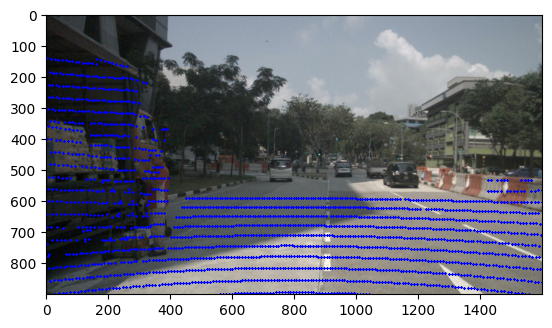

In [110]:
def show_tensor_with_coordinates(image, pixel):
    image = image.permute(1, 2, 0).type(torch.uint8).numpy()
    
    x = pixel[:,0].numpy()
    y = pixel[:,1].numpy()
    
    # # x, y 좌표를 그립니다.
    # x, y = coordinates[:, 0], coordinates[:, 1]
    # plt.scatter(x, y, c='red', marker='o')
    
    # 그래프를 표시합니다.
    plt.imshow(image)
    plt.scatter(x, y, c='blue', marker='x', s=1)
    # plt.axis('off')
    plt.show()
    
show_tensor_with_coordinates

sample = nuscene.scene_map['cc8c0bf57f984915a77078b10eb33198'].sample_list[3]
lidar = sample.sample_data_list[0]
cam = sample.sample_data_list[2]
image = cam.get_image()

points = lidar.get_points()
pixels, depths = cam.points_to_pixel2(points)
x = pixels[:,0]
y = pixels[:,1]

mask = torch.ones(pixels.shape[0], dtype=bool)
mask = torch.logical_and(mask, depths > 1.0)
mask = torch.logical_and(mask, x > 1)
mask = torch.logical_and(mask, x < 1600 - 1)
mask = torch.logical_and(mask, y > 1)
mask = torch.logical_and(mask, y < 900 - 1)

new_points = color_points(image, points, pixels)

camera_pos = torch.zeros((1,9))
camera_pos[:,:3] = cam.to_world(camera_pos[:,:3])
print(camera_pos[0].shape)

show_tensor_with_coordinates(image, pixels[mask])

In [112]:
create_las('./test.las', new_points)

21163 points were saved on ./test.las.
